# Homework Assignment 1
### The Art of Analyzing Big Data- The Data Scientist’s Toolbox 

For this homework you will need to write code that analyzes real-world datasets. The code needs to be written in Python using the [sqlite3](https://docs.python.org/2/library/sqlite3.html) package. 

**Please note:** You need to answer only the questions that match your ID first digit.

In [2]:
import sqlite3
from os import listdir
from os.path import isfile, join
import csv
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer

In [3]:
ds_path = 'datasets/'  # Path to directory containing all the datasets folders

# Babies Names Dataset

**Task 1 (for everyone):** Write a code that uses the  [babies names dataset](https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-data-by-state-and-district-of-#topic=developers_navigation) and creates a table named (Names) with the dataset data and the following columns: 'State', 'Gender', 'Name', 'Number' (5pt)
**Bonus:** Load the data using a Batch INSERT SQL Query (5pt)

In [4]:
conn = sqlite3.connect(ds_path+'yuval_database.db')
file_names = [f for f in listdir(ds_path+'namesbystate') if isfile(join(ds_path+'namesbystate', f))]
c = conn.cursor()

In [8]:
c.execute(""" CREATE TABLE IF NOT EXISTS Names (
                                    State text,
                                    Gender text,
                                    Year integer,
                                    Name text,
                                    Number integer
                                ); """)

In [9]:
for file in file_names:
    if 'TXT' in file:
        with open(ds_path+'namesbystate' + "/" + file,'r') as fin: 
            dr = csv.DictReader(fin, fieldnames=['State', 'Gender', 'Year','Name', 'Number'])
            to_db = [(i['State'], i['Gender'], i['Year'], i['Name'], i['Number']) for i in dr]
        c.executemany("INSERT INTO Names (State, Gender, Year, Name, Number) VALUES (?, ?, ?, ?, ?);", to_db)
conn.commit()

**Task 2 (for everyone):** Write a query that returns the statistics for the name Mary (5pt). Use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run (5pt). [Create an index](https://www.w3schools.com/sql/sql_create_index.asp)  on the _Name_ column and use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run with the index (10pt)

In [10]:
start = timer()
pd.read_sql_query(""" SELECT a.Year, CAST(number_of_baby_Mary AS float) /cast(sum_babies as float) as Mary_proportion
                      FROM(SELECT Year, SUM(Number) as number_of_baby_Mary
                          FROM Names
                          WHERE Name='Mary'
                          GROUP BY Year) as a
                          JOIN (SELECT Year, SUM(Number) as sum_babies
                          FROM Names
                          GROUP BY Year) as b
                          on a.YEAR=b.YEAR; """, conn)
end = timer()
time_before_idx = end - start
print('Time without index is {} sec'.format(time_before_idx))

Time without index is 5.3278568 sec


In [11]:
# Add index for Name
c.execute(""" CREATE INDEX Name_index
                ON Names (Name); """)

Time with index is 4.2712725 sec which is 1.2473699114256933 times faster


Text(0,0.5,'# Mary/ # babies')

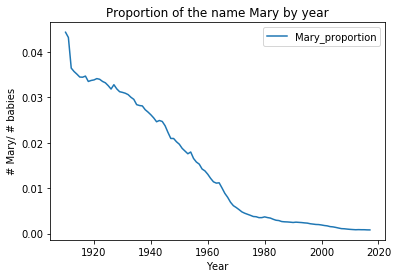

In [12]:
start = timer()
df = pd.read_sql_query(""" SELECT a.Year, CAST(number_of_baby_Mary AS float) /cast(sum_babies as float) as Mary_proportion
                      FROM(SELECT Year, SUM(Number) as number_of_baby_Mary
                          FROM Names
                          WHERE Name='Mary'
                          GROUP BY Year) as a
                          JOIN (SELECT Year, SUM(Number) as sum_babies
                          FROM Names
                          GROUP BY Year) as b
                          on a.YEAR=b.YEAR; """, conn)
end = timer()
time_after_idx = end - start
print('Time with index is {} sec which is {} times faster'.format(time_after_idx, time_before_idx/time_after_idx) )

# Plot of the statistics - proportion of babies with the name Mary by year:
df.plot(x='Year')
plt.title('Proportion of the name Mary by year')
plt.ylabel('# Mary/ # babies')

### <span style="color:red"> Please answer only **one** of the following questions according to your ID number (use the formula **<YOUR_ID> mod 4 +1**) </span>

In [13]:
# which question to answer - put your ID number and run the code 
your_id  = "302957139"
q = int(your_id) % 4 + 1
print("You need to answer question number %s" % q)

You need to answer question number 4


***Question 1:*** Write a function that returns how many babies were born in a given state in a given year.
Use it to calculate the number of babies born in LA in 1950 (15pt)

***Question 2:*** Write a function that returns how many male babies were born between a given range of years.
Use it to calculate how many babies were born between 1970 and 1975  (15pt)

**Question 3:** Write a function that returns the most common female name in a given state. Use it to calculate the most common female name in Wasington in 1987 (15pt)

**Question 4:** Write a function that returns how many more male babies named _William_ where born in a given state in a given year. Use it to find the state in which the highest number of babies _William_ where born in 1999 (15pt)

In [14]:
def William_year_state(state, year):
    return int(pd.read_sql_query(""" SELECT sum(Number) as num_Williams
                                      FROM Names
                                      WHERE State='"""+state+"""' AND Year='"""+year+"""' AND Name='William'
                                      ; """ , conn)['num_Williams'][0])


# Create the user-defined function
conn.create_function('William_by_state_year', 2, William_year_state)

# Use the function to find the state in which the highest number of babies William where born in 1999
pd.read_sql_query(""" SELECT State, MAX(wili) as num_williams_1999 FROM
                        (SELECT State, William_by_state_year(State, '1999') as wili
                        FROM (SELECT distinct State
                              FROM Names));""", conn)

,State,num_williams_1999
0,CA,1696


**Question (for everyone):** For the state of NY write code that calculates the second most popular female/male names in each decade in each state (10pt). Visualize it somehow using Matplotlib (5pt)

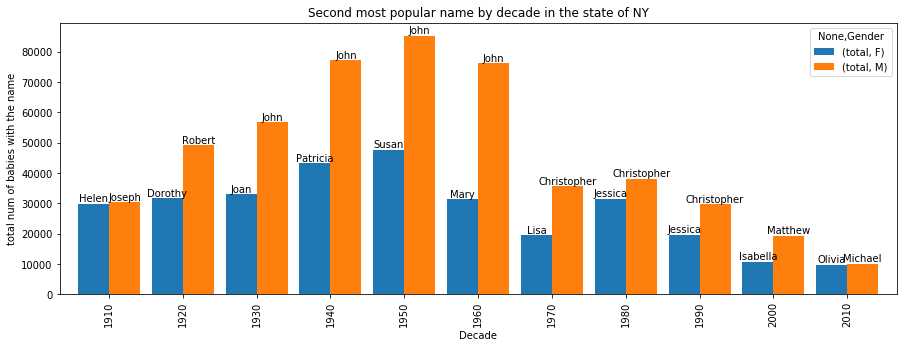

In [15]:
# Since the question is a bit unclear, I assumed that I only need to calculate for NY and not for each state!

df = pd.read_sql_query('''SELECT Decade, Gender, Name, total from (SELECT a.*
                          FROM (SELECT (cast((Year / 10) as INT) * 10) as Decade, Gender, Name, SUM(Number) as total
                                FROM Names
                                WHERE State='NY'
                                GROUP BY 1,2,3
                                ORDER BY 1,2,4 ASC) as a
                                LEFT JOIN (SELECT Decade, Gender, Name, total
                                           FROM (SELECT (cast((Year / 10) as INT) * 10) as Decade, Gender, Name, SUM(Number) as total
                                                 FROM Names
                                                 WHERE State='NY'
                                                 GROUP BY 1,2,3
                                                 ORDER BY 1,2,4 ASC) 
                                                 GROUP BY Decade, Gender) as b on a.Decade = b.Decade AND 
                                                            a.Gender = b.Gender AND a.Name = b.Name AND a.total = b.total
                                                            WHERE b.Name IS NULL)
                                                            GROUP BY Decade, Gender;''', conn)

labels = df['Name']
df.pivot(index='Decade', columns='Gender', values=['total']).plot.bar(width=0.84, figsize=(15,5))
plt.title('Second most popular name by decade in the state of NY')
plt.ylabel('total num of babies with the name')
ax = plt.gca()
rects = ax.patches


# for rect, label:
k = 1
j = 0
for i in range(labels.shape[0]):
    if i < labels.shape[0]/2:
        label = labels[j]
        j+=2
    else:
        label = labels[k]
        k+=2
    rect = rects[i]   
    height = rect.get_height()
    ax.text(rect.get_x()+ rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    i+=1

# Flavors of Cacao Dataset

Using the [Flavors of Cacao](https://www.kaggle.com/rombikuboktaeder/choco-flavors) dataset, answer the following questions:

**Question 1:** Write a function that returns the number of bars manufactured where the bars' BroadBean Origin is a given country. Use the function to calculate the number of bars where BroadBean Origin is 'Fiji' (15 pt)

**Question 2:** Write a function that returns the maximal and average cocoa percentage in a bar manufactured by a company in a specific country. Use the function to calculate the maximal and average cocoa percentage in bars manufactured by a Swiss company (15pt).

**Question 3:** Calculate the second most common bean type(s) and the most rare bean type(s) (15pt)

**Question 4:** Calculate the number of reviews and the average rating in each year. Calculate the number of reviews and the average rating of each company in each year (15pt)

In [16]:
c.execute(""" CREATE TABLE IF NOT EXISTS Coco (
                                    Company text,
                                    Review_Date integer,
                                    Rating float
                                ); """)

In [17]:
path = 'choco-flavors/flavors_of_cacao.csv'
with open(ds_path+path,'r') as fin: # `with` statement available in 2.5+
        # csv.DictReader uses first line in file for column headings by default
        dr = csv.reader(fin) # comma is default delimiter
        next(dr)
        to_db = [(i[0], i[3], i[6]) for i in dr]
c.executemany("INSERT INTO Coco (Company, Review_Date, Rating) VALUES (?, ?, ?);", to_db)
conn.commit()

In [18]:
pd.read_sql_query(""" SELECT Review_Date, COUNT(Review_Date) as num_reviews, AVG(Rating) as average_rating
                      FROM Coco
                      GROUP BY Review_Date; """, conn)

,Review_Date,num_reviews,average_rating
0,2006,72,3.125000
1,2007,77,3.162338
2,2008,93,2.994624
3,2009,123,3.073171
4,2010,111,3.148649
5,2011,165,3.256061
6,2012,195,3.178205
7,2013,184,3.197011
8,2014,247,3.189271
9,2015,285,3.246491


In [19]:
pd.read_sql_query(""" SELECT Review_Date, Company, COUNT(Review_Date) as num_reviews, AVG(Rating) as average_rating
                      FROM Coco
                      GROUP BY Review_Date, Company
                      ORDER BY Review_Date, average_rating ASC; """, conn)

,Review_Date,Company,num_reviews,average_rating
0,2006,Cote d' Or (Kraft),1,1.000000
1,2006,Dolfin (Belcolade),1,1.500000
2,2006,Jacque Torres,1,2.000000
3,2006,Green & Black's (ICAM),1,2.500000
4,2006,Scharffen Berger,5,2.500000
5,2006,Neuhaus (Callebaut),3,2.583333
6,2006,El Rey,1,2.750000
7,2006,Michel Cluizel,7,3.000000
8,2006,Original Hawaiin Chocolate Factory,1,3.000000
9,2006,Santander (Compania Nacional),3,3.000000


# Kickstarter Projects Dataset

Using the [Kickstarter Projects Dataset](https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv), answer the following questions:

### <span style="color:red"> Please answer only **one** of the following questions according to your ID number (use the formula **<YOUR_ID> mod 3 +1**) </span>

In [20]:
# which question to answer - put your ID number and run the code 
your_id  = "302957139"
q = int(your_id) % 3 + 1
print("You need to answer question number %s" % q)

You need to answer question number 1


**Question 1:** On average which project category received the highest number of backers? (15 pt)

In [5]:
# I assumed one table contains the records of the other

c.execute(""" CREATE TABLE IF NOT EXISTS KickStart (
                                    Category text,
                                    Backers integer
                                ); """)

In [6]:
path = 'kickstarter-projects/ks-projects-201801.csv'  

# I assumed this table also contains the records of the other table so I used only this one !!

with open(ds_path+path, encoding="utf8") as fin: 
        dr = csv.DictReader(fin) 
        to_db = [(i['category'], i['backers']) for i in dr]
c.executemany("INSERT INTO KickStart (Category, Backers) VALUES (?, ?);", to_db)
conn.commit()

In [13]:
# I assumed I need to use column 'category' and not 'main_categoty'

pd.read_sql_query(""" SELECT Category, MAX(average_backers) as average_backers
                      FROM (SELECT Category, AVG(Backers) as average_backers
                      FROM KickStart
                      GROUP BY Category); """, conn)

,Category,average_backers
0,Chiptune,443.942857


**Question 2:** On average which project category received the highest pledged USD? (15 pt)

**Question 3:** In which month occurred the highest number of projects? (15 pt)

## Oscars Datasets

Using the [Oscars Dataset](https://www.kaggle.com/theacademy/academy-awards), answer the following questions:

**Question 1:** Who is the female actress with the most Oscar nominees? (10pt)

In [24]:
# I was not sure if I need to answer question 1 or 4, answered both

c.execute(""" CREATE TABLE IF NOT EXISTS Oscar (
                                    Award text,
                                    Name text
                                    ); """)

In [25]:
path = 'academy-awards/database.csv'
with open(ds_path+path, encoding='utf8') as fin: # `with` statement available in 2.5+
        # csv.DictReader uses first line in file for column headings by default
        dr = csv.DictReader(fin) # comma is default delimiter
        to_db = [(i['Award'], i['Name']) for i in dr]
c.executemany("INSERT INTO Oscar (Award, Name) VALUES (?, ?);", to_db)
conn.commit()

In [26]:
pd.read_sql_query(""" SELECT *
                      FROM(SELECT Name, COUNT(Name) as num_nominees 
                           FROM Oscar
                           WHERE Award LIKE 'Actress%'              
                           GROUP BY Name
                           ORDER BY num_nominees ASC)
                      WHERE num_nominees = (SELECT nominees 
                                           FROM((SELECT Name, MAX(num_nominees) as nominees
                                                 FROM(SELECT Name, COUNT(Name) as num_nominees 
                                                      FROM Oscar
                                                      WHERE Award LIKE 'Actress%'            
                                                      GROUP BY Name)))); """, conn)

,Name,num_nominees
0,Meryl Streep,19


**Question 2:** Who is the male director with the most Oscar nominees? (10pt)

**Question 3:** Which top-10 movies received the highest number of Oscar nominees? (10pt)

**Question 4:** Write a function that receives an actor's name and returns the actor’s number of Oscar nominees. Use the function to calculate the number of times Leonardo DiCaprio was a nominee (10pt)

In [27]:
def actor_nominees(name):
    return int(pd.read_sql_query('''SELECT Name, COUNT(Name) as num_nominees 
                              FROM Oscar
                              WHERE Award LIKE 'Actor%' and name LIKE "%'''+name+'''%";''', conn)['num_nominees'][0])


conn.create_function('actor_nominees', 1, actor_nominees)
c.execute('''CREATE TABLE IF NOT EXISTS answer (Name text, num_nominees integer)''')
question = ('Leonardo DiCaprio', 'Leonardo DiCaprio')
c.execute('''INSERT INTO answer(Name , num_nominees) VALUES (?, actor_nominees(?))''', question)
pd.read_sql_query( """ SELECT * FROM answer; """, conn)

,Name,num_nominees
0,Leonardo DiCaprio,5


## Select a Dataset

**Open Question:** Select an interesting dataset and use SQL to discover something interesting (10pt)

## My choice: 
I chose two datasets: [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) which holds data on gun crimes between 1/1/2013 and 3/31/2018 by US state, and [US population](https://datamarket.com/data/set/4m86/us-population-by-state-and-county#!ds=4m86!7x53=7:7x52=2.3.4.5.6.7.8.9.a.b.c.d.e.f.g.h.i.j.k.l.m.n.o.p.q.r.s.t.u.v.w.x.y.z.10.11.12.13.14.1h.15.16.17.18.19.1a.1b.1c.1d.1e.1f.1g:8sf4=1&display=barstack) that details the number of residents by state in the US.

In [36]:
c.execute(""" CREATE TABLE IF NOT EXISTS Guns (
                                    state text,
                                    n_killed text,
                                    n_injured text,
                                    gun_type text); """)

c.execute(""" CREATE TABLE IF NOT EXISTS Population (
                                    state text,
                                    n_residents integer); """)

path = 'datasets/crime/us_population_by_state.csv'
with open(path, encoding='utf8') as fin: 
        dr = csv.DictReader(fin)
        to_db = [(i['state'], i['n_residents']) for i in dr]
        c.executemany("INSERT INTO Population (state, n_residents) VALUES (?, ?);", to_db)
    
path = 'datasets/crime/gun-violence-data_01-2013_03-2018.csv'
with open(path, encoding='utf-8', errors='ignore') as fin: 
        dr = csv.DictReader(fin) 
        to_db = [(i['state'], i['n_killed'], i['n_injured'], i['gun_type']) for i in dr]
        c.executemany("INSERT INTO Guns (state, n_killed, n_injured, gun_type) VALUES (?, ?, ?, ?);", to_db)


Text(0,0.5,'Num of fatalities')

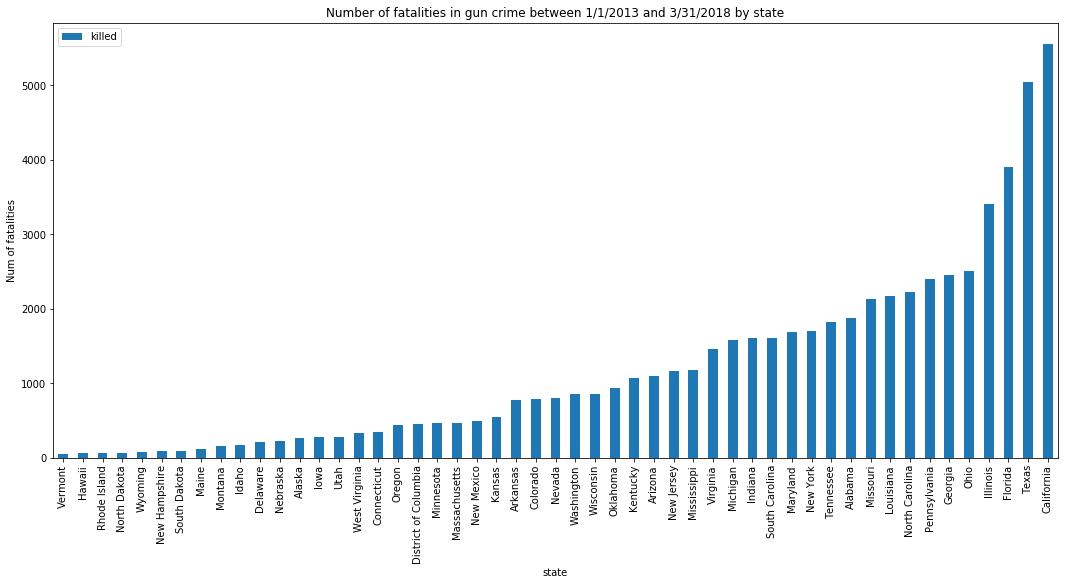

In [37]:
# Here I query and plot the number of fatalities in gun crime by state

pd.read_sql_query('''SELECT state, sum(n_killed) as killed 
                     FROM Guns group by state
                     ORDER BY killed ASC;''', conn).plot.bar(x='state', figsize=(18,8))

plt.title('Number of fatalities in gun crime between 1/1/2013 and 3/31/2018 by state')
plt.ylabel('Num of fatalities')

Text(0,0.5,'Proportion of fatalities')

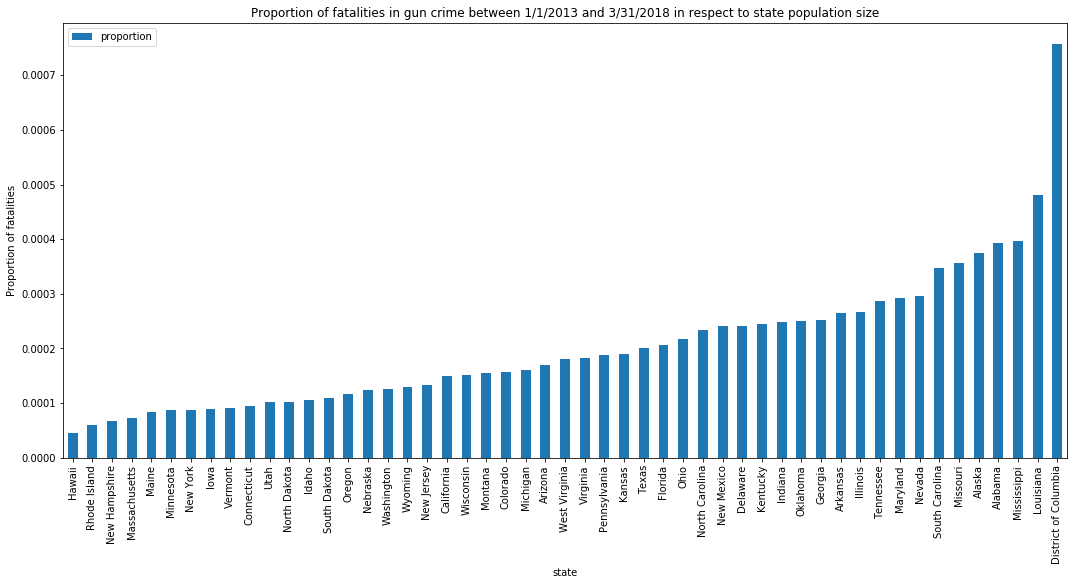

In [38]:
# Here I query and plot the proportion of fatalities in gun crime by state in respect to the population size

pd.read_sql_query('''SELECT a.state, CAST(killed AS float) /cast(n_residents as float) as proportion 
                     FROM (SELECT state, sum(n_killed) as killed from Guns group by state) as a
                     JOIN (select * from Population) as b 
                     on a.state=b.state ORDER BY proportion ASC;''', conn).plot.bar(x='state', figsize=(18,8))

plt.title('Proportion of fatalities in gun crime between 1/1/2013 and 3/31/2018 in respect to state population size')
plt.ylabel('Proportion of fatalities')

Text(0,0.5,'Proportion of fatalities in respect to the number of casualties')

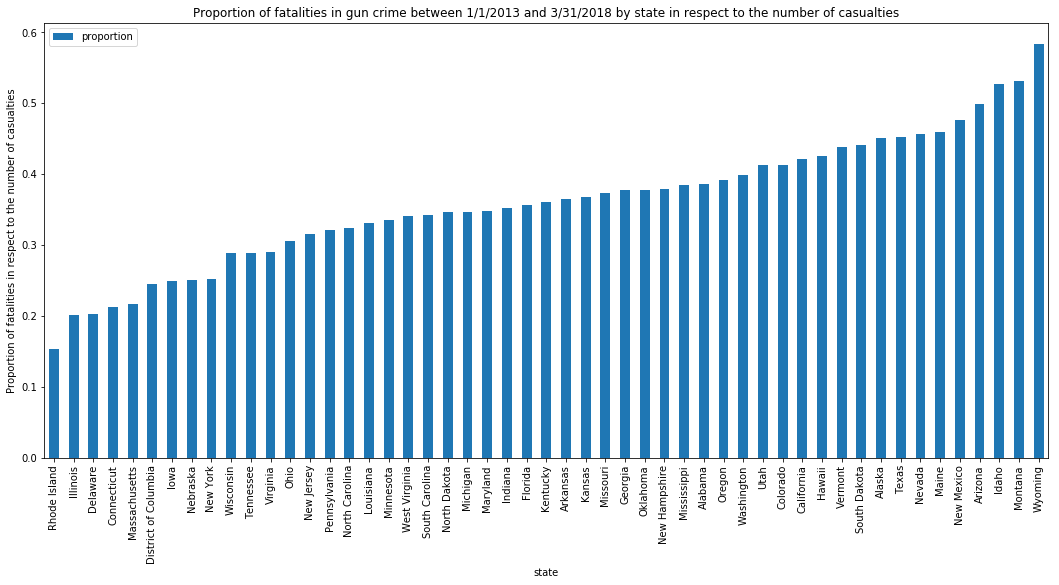

In [39]:
# Here I query and plot the proportion of fatalities in gun crime by state in respect to the overall number of casualties in the gun crimes

pd.read_sql_query('''SELECT state, CAST(killed AS float) /cast(injured+killed as float) as proportion
                     FROM (SELECT state, sum(n_killed) as killed, sum(n_injured) as injured 
                        FROM Guns group by state)
                        ORDER BY proportion ASC;''', conn).plot.bar(x='state', figsize=(18,8))

plt.title('Proportion of fatalities in gun crime between 1/1/2013 and 3/31/2018 by state in respect to the number of casualties')
plt.ylabel('Proportion of fatalities in respect to the number of casualties') 

# Conclusions
We can see for example that while Hawaii has the smallest proportion of fatalities due to gun crime out of all states, the crimes there are more severe and result in higher proportion of fatalities out of the total number of casualties in the crime.

In [40]:
c.close()
conn.close()